In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import segyio
import matplotlib.pyplot as plt

from scipy.signal import filtfilt

from refrtomo.survey import *
from refrtomo.tomomatrix import *
from refrtomo.segyshot import SegyShot, rotate

# Rayshooting

The purpose of this notebook is to showcase how our refraction tomography will look like without running the inversion our using the real traveltimes. The ray shooting depends uniquely on the geometry of the acquisition and the initial velocity model. We will compare the rays traveltimes obtained after solving the ODE's with the raytracer and the traveltime computed from the initial tomographic matrix.

In [2]:
# Import the 2D seismic data and 3D Velocity model
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

# Open the 2D seismic data
f = segyio.open(inputfile, ignore_geometry=True)

In [3]:
# Number of traces
nTraces = f.bin[segyio.BinField.Traces]
print(f"Number of traces = {nTraces}")

# Create the SegyShot object
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
# Scan the shot gathers and get attributes
sg.interpret()

# Get time axis
t = sg.t
dt = t[1] - t[0]
print(f"dt = {dt} ms")

# Store attributes
nSrc = sg.nsrc  # number of sources
nRec = sg.nrec  # number of receivers
nT = sg.nt      # number of time samples

print(f"Number of sources = {nSrc}")
print(f"Number of receivers = {nRec}")
print(f"Number of time samples = {nT}")

Number of traces = 960
dt = 0.002 ms
Number of sources = 30
Number of receivers = 240
Number of time samples = 2000


We need to be careful to decide which slice from the migration velocity model 3D dataset to use. In the code above, we find that the inline 10 is closest to the receivers, and also to the sources 15 sources 
closest to the receivers. Instead, the inline 11 is adjacent to the other parallel subset of 15 sources. We then select the inline 10 to perform the ray shooting, as it is a more representative model to our acquisition location. 

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109
Inline number = 10


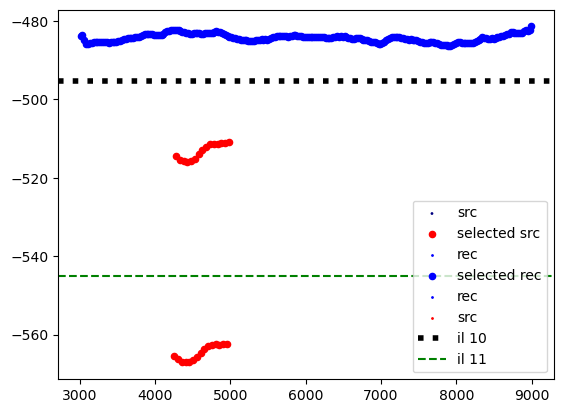

In [4]:
# Pressure shot gather (note that for each receiver the data is organized as follows: P,VZ,VX,VY.
# So we take every 4th trace)
fv = segyio.open(velfile)

# Depth axes
z = fv.samples[0:186]
dz = z[1] - z[0]
il, xl = fv.ilines, fv.xlines
# Velocity model
vmod = segyio.cube(velfile)

# local regular axis
vdx, vnx, vdy, vny = sg.rotategeometry(velfile=velfile, plotflag=0)
sg.showgeometry(local=True)

# Create the local regular axis
v_x = np.arange(0, vnx * vdx, vdx)
v_y = - np.arange(0, vny * vdy, vdy)
# Compute the indices in v_y that closely match each value in sg.recy_local
il_rec_idx = np.abs(sg.recy_local[:, None] - v_y).argmin(axis=1)
il_src_idx = np.abs(sg.srcy_local[:, None] - v_y).argmin(axis=1)

# Get the inline closest to the receivers
inline = il_rec_idx[0]

# Select the closest inline to geometry of the 2D seismic data
vmod2d = vmod[inline, :, 0:186]
# Print inline number
print(f"Inline number = {inline}")

# Show where the closest inlines are 
plt.scatter(sg.recx_local, sg.recy_local, color='b', s=1, label='rec')
plt.scatter(sg.srcx_local, sg.srcy_local, c='r', s=1, cmap='jet', label='src')
plt.axhline(v_y[il_rec_idx[0]], linestyle=":", c='black', linewidth=4, label=f"il {il_rec_idx[0]}")
plt.axhline(v_y[il_src_idx[0]], linestyle="--", c='g', label=f"il {il_src_idx[0]}")
plt.legend()
plt.show()

Our initial 2D velocity model is a smoothed version of the migration velocity model. We will use this model to perform the ray shooting.

In [5]:
# Initial velocity (smooth migration velocity)
nsmooth = 5
vel_init = vmod2d.copy()[50:190, 0:186]
for _ in range(4):
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=1)
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=0)

# Extract the velocity local coordinates
with segyio.open(velfile, "r") as vel:
    scvel = vel.header[0][segyio.TraceField.SourceGroupScalar]
    if scvel < 0:
        scvel = 1. / abs(scvel)
    xvel = scvel * vel.attributes(segyio.TraceField.CDP_X)[xl.size*(inline):xl.size*(inline+1)]
    yvel = scvel * vel.attributes(segyio.TraceField.CDP_Y)[xl.size*(inline):xl.size*(inline+1)]
    rot, ox, oy = segyio.tools.rotation(vel, line='fast')
    ox, oy = scvel * ox, scvel * oy
    rot = (rot - np.pi / 2)

    xvel_local, yvel_local = rotate(xvel, yvel, ox, oy, rot)

# Short laterally the x, y coordiantes
xvel_local = xvel_local[50:190]
yvel_local = yvel_local[50:190]

Display the smooth velocity model.

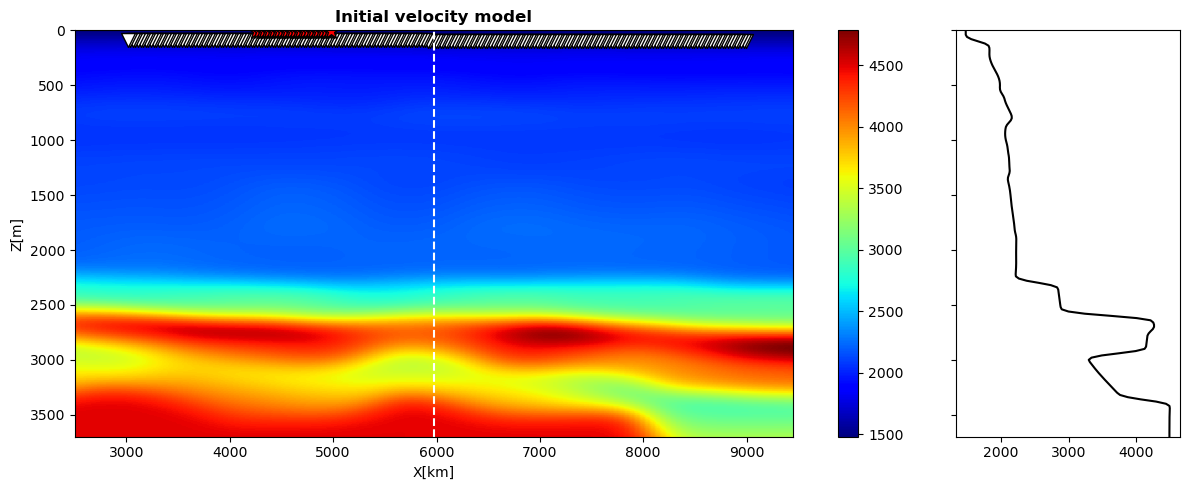

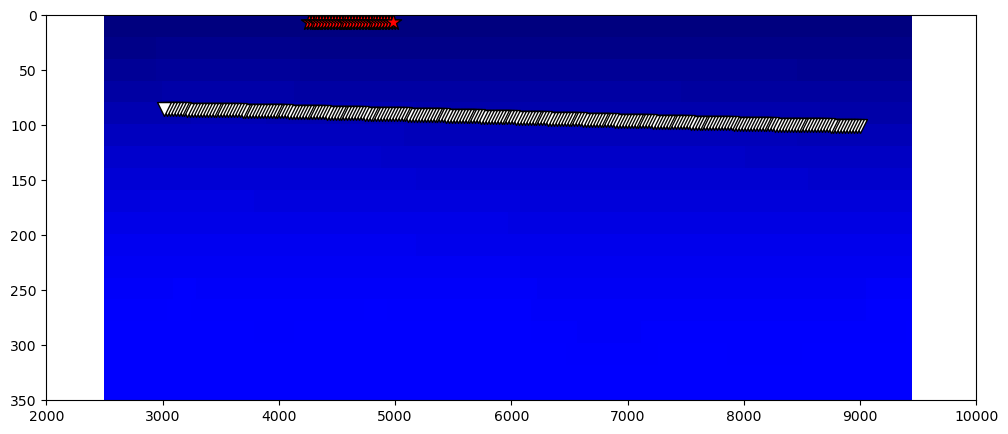

In [6]:
# Display velocity model
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im = axs[0].imshow(vel_init.T, extent=(xvel_local[0], xvel_local[-1], z[-1], z[0]), cmap='jet')
# Show sources and recieverss
axs[0].scatter(sg.recx_local, sg.recz, marker='v', s=100, c='w', edgecolors='k')
axs[0].scatter(sg.srcx_local, sg.srcz, marker='*', s=150, c='r', edgecolors='k')

axs[0].axvline(v_x[120], color='w', linestyle='--')
axs[0].set_title('Initial velocity model', fontweight='bold')
axs[0].set_xlabel('X[km]')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
cbar = fig.colorbar(im, ax=axs[0]) 
axs[1].plot(vmod2d[120], z, 'k')
plt.tight_layout();

# Zoom in the velocity model
plt.figure(figsize=(12, 5))
plt.imshow(vel_init.T, extent=(xvel_local[0], xvel_local[-1], z[-1], z[0]), cmap='jet')
plt.scatter(sg.recx_local, sg.recz, marker='v', s=100, c='w', edgecolors='k')
plt.scatter(sg.srcx_local, sg.srcz, marker='*', s=150, c='r', edgecolors='k')

plt.xlim(2000, 10000)
plt.ylim(350, 0) 
plt.gca().set_aspect('auto')

## Shoot rays for one source

#### 1. Define survey geometry

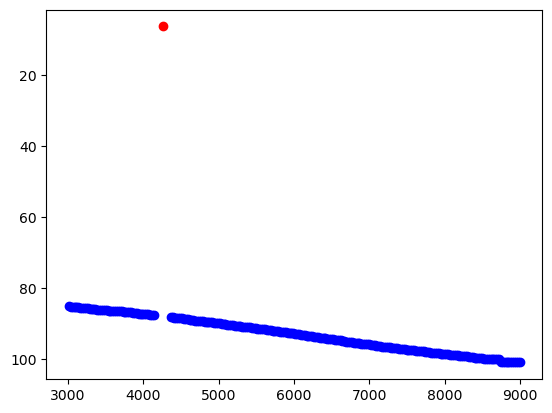

In [7]:
# Stack sources and receivers coordinates
srcs = np.vstack((sg.srcx_local[0], sg.srcz[0]))
recs = np.vstack((sg.recx_local, sg.recz))

# Define a minimum offset of 100m
survey = survey_geom(srcs, recs, minoffset=100)
plt.gca().invert_yaxis()
display_survey(survey)

#### 2. Define the parameters for the raytracer

As our model is very large and velocities are high, we require to shoot a large number of rays to ensure that we have rays that reach deeper layers.

In [8]:
# Lenght and steps of rays
lmax = 20000
nl = 20000

# Choose angles to shoot rays, considering the size of the vel. model
thetas = np.hstack([np.arange(-70, -0.2, 0.1), np.arange(0.2, 70, 0.1)])

#### 3. Choose horizontal and vertical tolerances for the rays

Since we don't have infinite number of rays, not necessarily all rays will reach the receivers at the exact locations. A certain tolerance must be set to not cut off rays that are close to the receivers. In our example, $5m \times 5m$ tolerance is used, which is reasonable considering that the velocity model is 3500m deep and 12000m long.

survey_raytrace: 232 Source-receiver pairs in survey, 14 Source-receiver paired with ray...


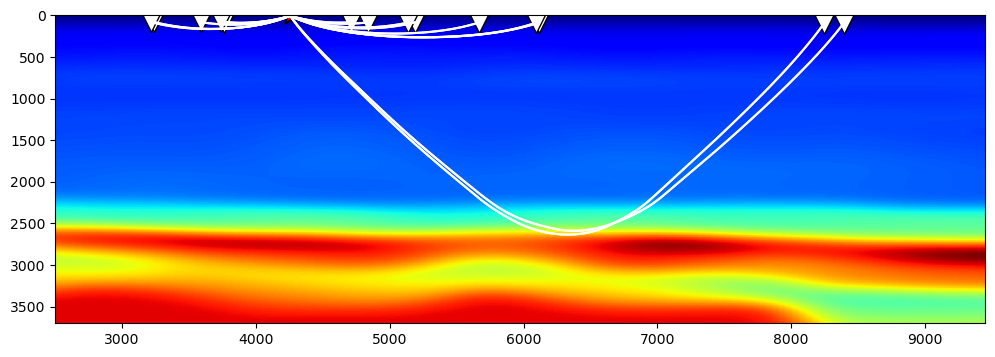

In [9]:
# Find rays that arrive to the receivers
initsurvey = survey_raytrace(survey, vel_init.T, xvel_local, z,\
     lmax, nl, thetas, dzout=5., ray_rec_mindistance=5., tolerance_z=5., debug=True)

# Display rays
display_survey_rays(initsurvey, vel_init.T, xvel_local, z, figsize=(12, 4))

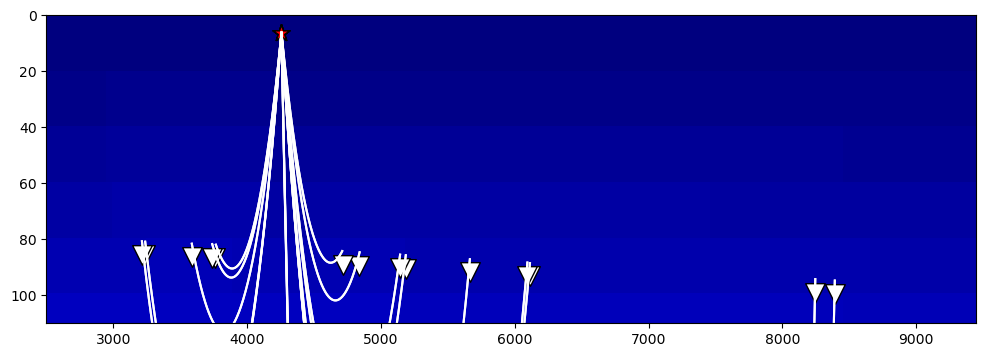

In [10]:
# Show it more closely
display_survey_rays(initsurvey, vel_init.T, xvel_local, z, figsize=(12, 4))
plt.ylim(110, 0);

We note that the rays are traveling the receivers in the way we intended to (with refractions instead of direct arrivals). Additionally, the rays are reaching the receivers at the correct locations.

#### 4. Create tomographic matrix

First, let's do the simplest example and take only one ra (i.e., one source and receiver pair). We will then compare the traveltime obtained from the raytracer with the traveltime obtained from the tomographic matrix.

In [11]:
# Obtain spacial parameters
dx = int(np.mean(np.abs(np.diff(xvel_local))))
dz = z[1] - z[0]
nx = len(xvel_local); 
nz = len(z)

print(f"nx = {nx}, nz = {nz}, velocity model shape ({vel_init.shape[0]}, {vel_init.shape[1]})")

nx = 140, nz = 186, velocity model shape (140, 186)


In [12]:
# single ray
iray = 10

R = [raytrace_straight(initsurvey[iray].ray[i], initsurvey[iray].ray[i+1], dx, dz, xvel_local, z[0], nx, nz, xvel_local, z)[0] 
     for i in range(initsurvey[iray].ray.shape[0]-1)]
R = np.sum(R, axis=0)

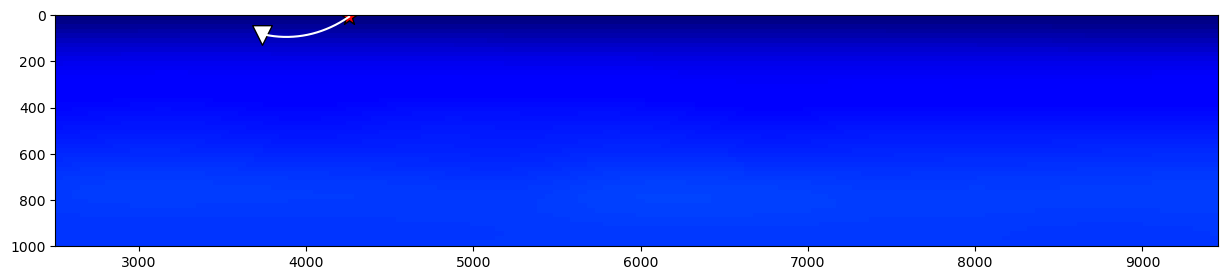

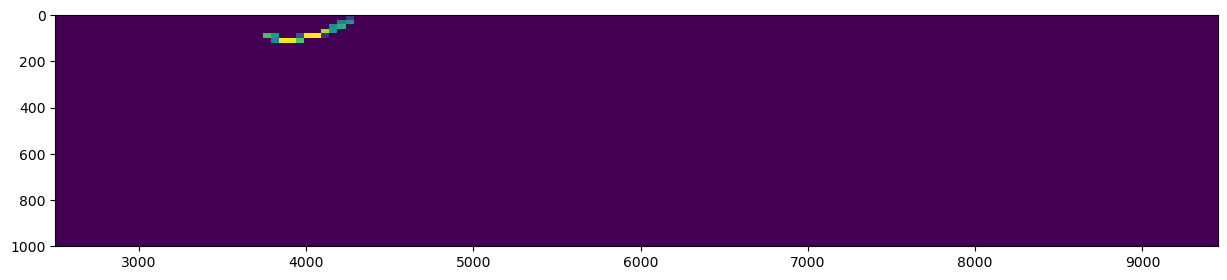

In [13]:
# Display ray
plt.figure(figsize=(15, 3))
plt.imshow(vel_init.T, cmap='jet', extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))

plt.plot(initsurvey[iray].ray[:,0], initsurvey[iray].ray[:,1], 'w')
plt.scatter(initsurvey[iray].src[0], initsurvey[iray].src[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(initsurvey[iray].rec[0], initsurvey[iray].rec[1], marker='v', s=200, c='w', edgecolors='k')
plt.axis('tight');
plt.ylim(1000, 0)
plt.figure(figsize=(15, 3))

# Show tomographic matrix
plt.imshow(R.reshape(nx, nz).T, extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))
plt.axis('tight');
plt.ylim(1000, 0)
plt.show()

In [14]:
# Extract the traveltime from the survey
tobs = extract_tobs(initsurvey)[iray]
# Compute the expected traveltime given the distances and velocities
tobs_R = R @ (1/vel_init.ravel())

tobs, tobs_R

(np.float64(0.33663042055734704), np.float64(0.3285400743707101))

There is an error of approximately 0.02 sec, which is understandable given the size of the grid. Now try with **all rays** from the given source.

In [15]:
# all rays
R = []
Rcove = np.zeros(nx*nz)
for iray, ray in enumerate(initsurvey):
    try:
        R_ = [raytrace_straight(ray.ray[i], ray.ray[i+1], dx, dz, xvel_local[0], z[0], nx, nz, xvel_local, z)[0] 
             for i in range(ray.ray.shape[0]-1)]
    except Exception as e:
        print(f" Ray # {iray} An error occurred:", str(e))
    R.append(np.sum(R_, axis=0))
    Rcove = Rcove + np.sum(R_, axis=0)
R = np.vstack(R)
print(R.shape)

(14, 26040)


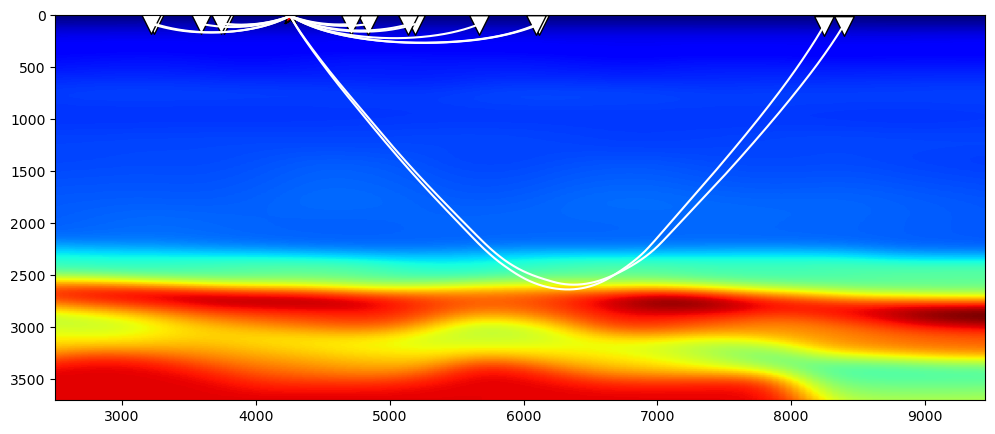

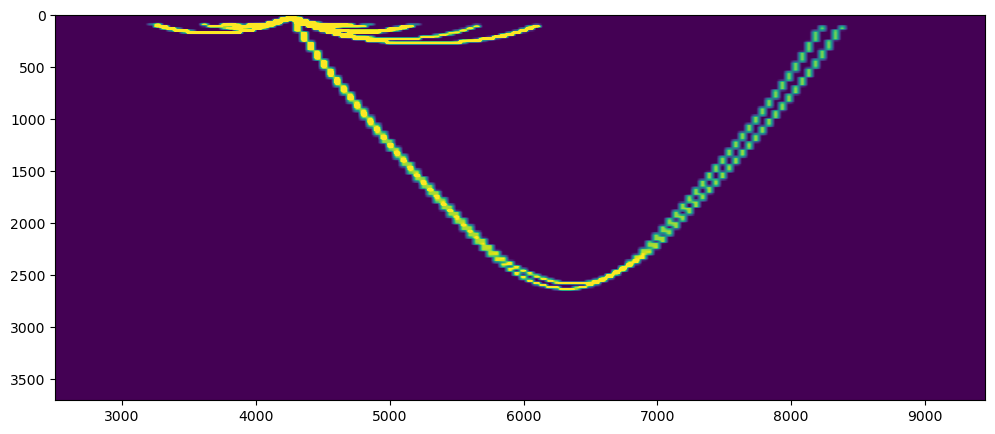

In [16]:
# Show results
plt.figure(figsize=(12, 5))
plt.imshow(vel_init.T, cmap='jet', extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))

for ray in initsurvey:
    plt.plot(ray.ray[:,0], ray.ray[:,1], 'w')
    plt.scatter(ray.src[0], ray.src[1], marker='*', s=150, c='r', edgecolors='k')
    plt.scatter(ray.rec[0], ray.rec[1], marker='v', s=200, c='w', edgecolors='k')
    plt.axis('tight');
# plt.ylim(1000, 0);
plt.figure(figsize=(12, 5))
plt.imshow(Rcove.reshape(nx, nz).T, vmin=0, vmax=np.max(Rcove)/10, extent = (xvel_local[0], xvel_local[-1], z[-1], z[0]))
plt.axis('tight')
plt.show()

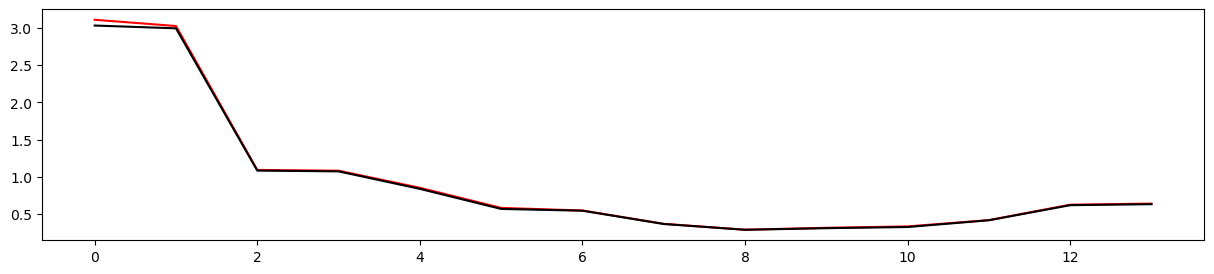

In [17]:
# Compare traveltimes
tobs = extract_tobs(initsurvey)
tobs_R = R @ (1/vel_init.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tobs_R, 'k');

#### Create the tomographic matrix with all rays

Show how the full survey looks like.

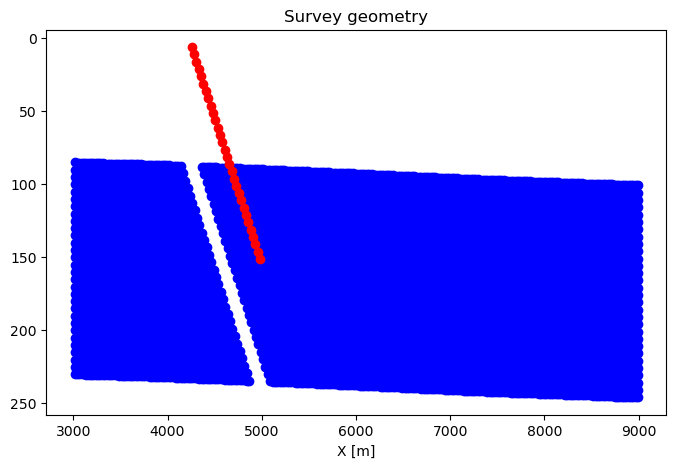

In [18]:
# Get sources and receivers x and z coordiantes
srcs = np.vstack((sg.srcx_local, sg.srcz))
recs = np.vstack((sg.recx_local, sg.recz))

survey = survey_geom(srcs, recs, minoffset=100)

# Display survey
plt.figure(figsize=(8, 5))
display_survey(survey)
plt.title('Survey geometry')
plt.xlabel('X [m]')
plt.gca().invert_yaxis()
plt.show()

In [19]:
# Lenght and steps of rays
lmax = 20000
nl = 20000

# Choose angles to shoot rays, considering the size of the vel. model
thetas = np.hstack([np.arange(-70, -0.2, 0.2), np.arange(0.2, 70, 0.2)])

# Find rays that arrive to the receivers
initsurvey = survey_raytrace(survey, vel_init.T, xvel_local, z,\
     lmax, nl, thetas, dzout=5., ray_rec_mindistance=5., debug=True)

survey_raytrace: 6960 Source-receiver pairs in survey, 323 Source-receiver paired with ray...


Construct matrix and compare rays and numerical traveltimes. Also compare it with the observed traveltimes from the first arrival picking.

tomographic_matrix: 323 rows, 26040 columns


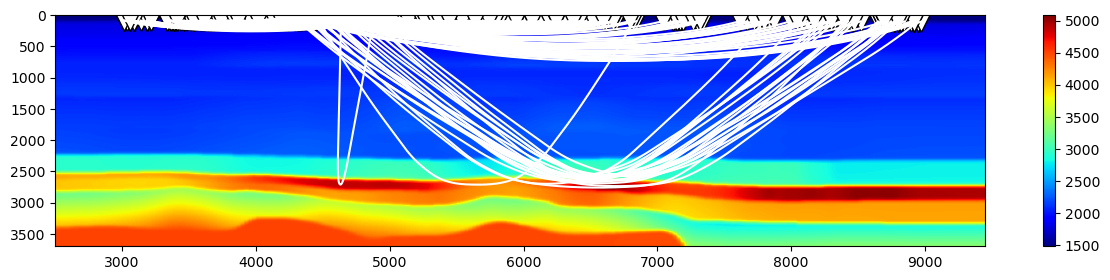

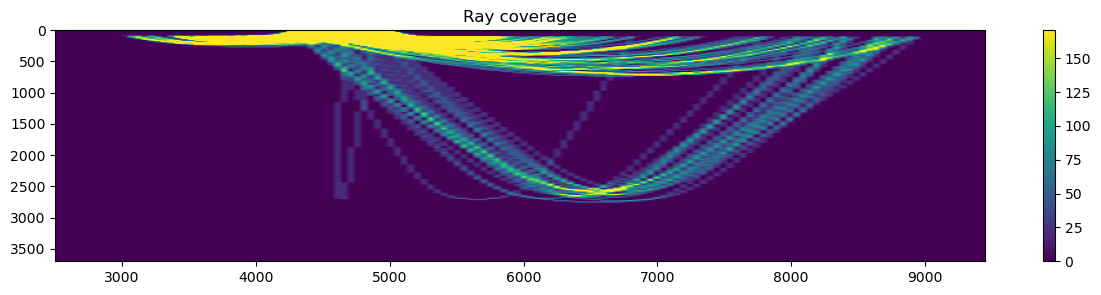

In [20]:
# Tomographic matrix
R = tomographic_matrix(initsurvey, dx, dz, xvel_local[0], z[0], nx, nz, xvel_local, z, 
                       debug=True, plotflag=True, vel=vmod2d, figsize=(15, 3))

In [21]:
# Import the First Arrival Traveltime data
tfile = '../data/FirstArrivalVolve.npz'
tfirsts = np.load(tfile)['tfirsts']

In [22]:
# Create avasurvey
avasurvey = avasurvey = survey_geom_observed(srcs, recs, tobs=tfirsts, minoffset=100)

# Match surveys
avasurvey_matched, initsurvey_matched = match_surveys(avasurvey, initsurvey)

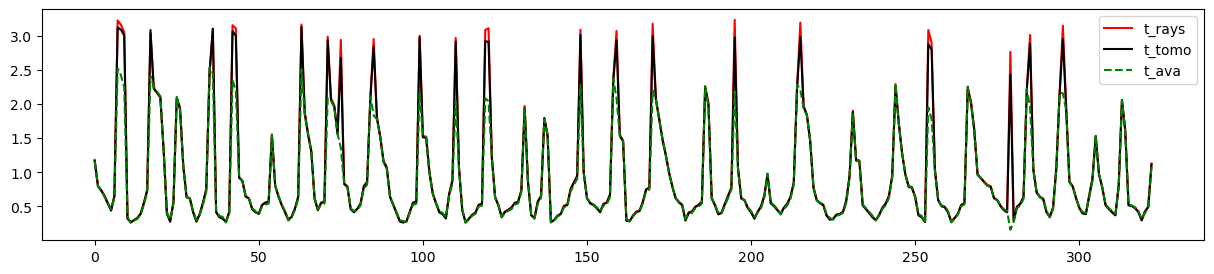

In [23]:
# Extract the matched traveltimes
tobs = extract_tobs(initsurvey_matched)
tobs_R = R @ (1/vel_init.ravel())
tbos_ava = extract_tobs(avasurvey_matched)

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r', label='t_rays')
plt.plot(tobs_R, 'k', label='t_tomo')
plt.plot(tbos_ava, 'g', ls='--', label='t_ava')
plt.legend()
plt.show()

The traveltimes of the tomography fall a bit behind of the rays probably due to the vertical tolerance, which make the rays "arrive" sooner. The observed traveltimes in general are lower than the obtained with the first guess, indicating rays turning faster than those generated initially.